# Predict player performance in a season

Wouldn't it be awesome to be able to predict what player that ? In this workbook, I will make an attempt to do this by using dataset about playerperformance. The dataset have been collected  with the package ```eliteprospect_scraper``` which collects data from www.eliteprospects.com   
Details about the package: [eliteprospect_scraper](https://github.com/msjoelin/eliteprospect_scraper)

Steps:
1. Import and preprocess data
2. Feature correlation
3. Prepare data for the machine learning model
4. Train model
5. Evaluate performance
6. Apply model to result current season and 

So let's start!

### 1) Import  packages and data


In [1]:
import numpy as np
import pandas as pd

# sklearn will be used to build the model
from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import train_test_split 
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

# To save the model
import pickle

# For visualization
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

pd.options.display.max_columns = None

In [3]:
# Import players data from the github repo
#url_players = 'https://raw.githubusercontent.com/msjoelin/icehockey_analysis/master/data/df_players.csv'
url_players = 'C:/Users/marcu/Documents/projects/icehockey_analytics/data/df_players.csv'

df_players = pd.read_csv(url_players, error_bad_lines=False)

print(df_players.shape[0], " rows imported")

df_players.head()

30992  rows imported


,link,season,team,league,gp,g,a,tp,pim,+/-,...,avg_g_vs_team_prev,avg_a_vs_team_prev,avg_tp_vs_team_prev,avg_g_vs_season_prev,avg_a_vs_season_prev,avg_tp_vs_season_prev,avg_g_team_vs_season_prev,avg_a_team_vs_season_prev,avg_tp_team_vs_season_prev,league_prev
0,https://www.eliteprospects.com/player/10014/me...,2005-06,Lycksele SK,division 2,9.0,1.0,2.0,3.0,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,https://www.eliteprospects.com/player/10014/me...,2006-07,Skellefteå AIK J18,j18 allsvenskan,14.0,5.0,4.0,9.0,20.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,division 2
2,https://www.eliteprospects.com/player/10014/me...,2007-08,Skellefteå AIK J18,j18 elit,16.0,10.0,8.0,18.0,4.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,j18 allsvenskan
3,https://www.eliteprospects.com/player/10014/me...,2008-09,Skellefteå AIK J20,superelit,34.0,10.0,14.0,24.0,58.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,j18 elit
4,https://www.eliteprospects.com/player/10014/me...,2009-10,Skellefteå AIK,shl,36.0,2.0,0.0,2.0,8.0,-2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,superelit


Lets narrow down the data a little bit. In this project I will limit the data to only SHL players starting from the season 2013-14. The dataset also contains many columns that probably doesnt impact the performance, so lets narrow down the data set a little bit. 


In [4]:
 # Select only shl players from season starting 2013-2014
df_players_shl = df_players[(df_players['league'] == 'shl') & 
                            (df_players['season'].isin(['2013-14' ,'2014-15', '2015-16',
                                                        '2016-17','2017-18', '2018-19', 
                                                        '2019-20', '2020-21']))].reset_index(drop=True)

# Select only relevant columns
df_players_shl = df_players_shl[['playername', 'fw_def', 'season', 'team', 'league',
                                 'avg_tp', 'avg_g', 'avg_a', '+/-',
                                'league_prev', 'league_seasons', 'team_seasons',
                                'avg_tp_prev', 'avg_g_prev', 'avg_a_prev', '+/-_prev',
                                'avg_tp_vs_team_prev', 'avg_tp_team_vs_season_prev', 'avg_tp_vs_team_prev']]

df_players_shl.head()


,playername,fw_def,season,team,league,avg_tp,avg_g,avg_a,+/-,league_prev,league_seasons,team_seasons,avg_tp_prev,avg_g_prev,avg_a_prev,+/-_prev,avg_tp_vs_team_prev,avg_tp_team_vs_season_prev,avg_tp_vs_team_prev
0,Melker Karlsson,FW,2013-14,Skellefteå AIK,shl,0.520833,0.187500,0.333333,-3.0,shl,5,5,0.636364,0.295455,0.340909,20.0,0.136482,0.511515,0.136482
1,Henrik Tömmernes,DEF,2015-16,Frölunda HC,shl,0.580000,0.200000,0.380000,12.0,ahl,5,5,0.478261,0.130435,0.347826,-3.0,NaN,NaN,NaN
2,Henrik Tömmernes,DEF,2016-17,Frölunda HC,shl,0.795918,0.163265,0.632653,2.0,shl,6,1,0.580000,0.200000,0.380000,12.0,0.983226,0.146669,0.983226
3,Niklas Arell,DEF,2013-14,Färjestad BK,shl,0.176471,0.039216,0.137255,-5.0,allsvenskan,1,1,0.326923,0.115385,0.211538,14.0,0.157308,0.221561,0.157308
4,Niklas Arell,DEF,2014-15,Färjestad BK,shl,0.116279,0.023256,0.093023,6.0,shl,2,2,0.176471,0.039216,0.137255,-5.0,-0.213149,0.000740,-0.213149


* ```avg_tp```: average points per game  
* ```avg_g```: average goals per game
* ```avg_a```: average assists per game
* ```+/-```: total +/- for the season
* ```league_prev```: The league where the player played previous season  
* ```league_seasons```: How many seasons the player has made in the league he is playing current season  
* ```team_seasons```: How many season the player has played in the team he is playing
* Ending with ```_prev```: Statistics for the previous season  
* ```avg_tp_vs_team_prev```: How many points the player last season compared to average for the team (playing on the same position). If positive, the player performed better than overall team  
* ```avg_tp_team_vs_season_prev```: How many points the team last season compared to overall for all teams that season (playing on the same position). If positive, the player played in a team that was making many points  

We have some categorical columns which we will turn into binary columns. This is done so we can use the data for predictions. 

In [5]:
# Add binary columns for previous league

df_players_shl['league_prev_shl'] = 0
df_players_shl.loc[(df_players_shl['league_prev'] == 'shl'), 'league_prev_shl'] = 1

df_players_shl['league_prev_allsvenskan'] = 0
df_players_shl.loc[(df_players_shl['league_prev'] == 'allsvenskan'), 'league_prev_allsvenskan'] = 1

df_players_shl['league_prev_superelit'] = 0
df_players_shl.loc[(df_players_shl['league_prev'] == 'superelit'), 'league_prev_superelit'] = 1

df_players_shl['league_prev_khl'] = 0
df_players_shl.loc[(df_players_shl['league_prev'] == 'khl'), 'league_prev_khl'] = 1

df_players_shl['league_prev_ahl'] = 0
df_players_shl.loc[(df_players_shl['league_prev'] == 'ahl'), 'league_prev_ahl'] = 1

df_players_shl['league_prev_other'] = 0
df_players_shl.loc[(df_players_shl['league_prev'] != 'shl') & 
                   (df_players_shl['league_prev'] != 'allsvenskan') & 
                   (df_players_shl['league_prev'] != 'superelit') & 
                   (df_players_shl['league_prev'] != 'khl') & 
                   (df_players_shl['league_prev'] != 'ahl') , 'league_prev_other'] = 1


# Binary variables for number of seasons in league
df_players_shl['league_seasons_first'] = 0
df_players_shl.loc[(df_players_shl['league_seasons'] == 1), 'league_seasons_first'] = 1

df_players_shl['league_seasons_second'] = 0
df_players_shl.loc[(df_players_shl['league_seasons'] == 2), 'league_seasons_second'] = 1

df_players_shl['league_seasons_three_or_more'] = 0
df_players_shl.loc[(df_players_shl['league_seasons'] > 2), 'league_seasons_three_or_more'] = 1

# Binary variables for number of seasons in team
df_players_shl['team_seasons_first'] = 0
df_players_shl.loc[(df_players_shl['team_seasons'] == 1), 'team_seasons_first'] = 1

df_players_shl['team_seasons_second'] = 0
df_players_shl.loc[(df_players_shl['team_seasons'] == 2), 'team_seasons_second'] = 1

df_players_shl['team_seasons_three_or_more'] = 0
df_players_shl.loc[(df_players_shl['team_seasons'] > 2), 'team_seasons_three_or_more'] = 1

# Binary variables for position
df_players_shl['defence'] = 0
df_players_shl.loc[(df_players_shl['fw_def'] == 'DEF'), 'defence'] = 1

df_players_shl['forward'] = 0
df_players_shl.loc[(df_players_shl['fw_def'] == 'FW'), 'forward'] = 1


,playername,fw_def,season,team,league,avg_tp,avg_g,avg_a,+/-,league_prev,league_seasons,team_seasons,avg_tp_prev,avg_g_prev,avg_a_prev,+/-_prev,avg_tp_vs_team_prev,avg_tp_team_vs_season_prev,avg_tp_vs_team_prev,league_prev_shl,league_prev_allsvenskan,league_prev_superelit,league_prev_khl,league_prev_ahl,league_prev_other,league_seasons_first,league_seasons_second,league_seasons_three_or_more,team_seasons_first,team_seasons_second,team_seasons_three_or_more,defence,forward
0,Melker Karlsson,FW,2013-14,Skellefteå AIK,shl,0.520833,0.187500,0.333333,-3.0,shl,5,5,0.636364,0.295455,0.340909,20.0,0.136482,0.511515,0.136482,1,0,0,0,0,0,0,0,1,0,0,1,0,1
1,Henrik Tömmernes,DEF,2015-16,Frölunda HC,shl,0.580000,0.200000,0.380000,12.0,ahl,5,5,0.478261,0.130435,0.347826,-3.0,NaN,NaN,NaN,0,0,0,0,1,0,0,0,1,0,0,1,1,0
2,Henrik Tömmernes,DEF,2016-17,Frölunda HC,shl,0.795918,0.163265,0.632653,2.0,shl,6,1,0.580000,0.200000,0.380000,12.0,0.983226,0.146669,0.983226,1,0,0,0,0,0,0,0,1,1,0,0,1,0
3,Niklas Arell,DEF,2013-14,Färjestad BK,shl,0.176471,0.039216,0.137255,-5.0,allsvenskan,1,1,0.326923,0.115385,0.211538,14.0,0.157308,0.221561,0.157308,0,1,0,0,0,0,1,0,0,1,0,0,1,0
4,Niklas Arell,DEF,2014-15,Färjestad BK,shl,0.116279,0.023256,0.093023,6.0,shl,2,2,0.176471,0.039216,0.137255,-5.0,-0.213149,0.000740,-0.213149,1,0,0,0,0,0,0,1,0,0,1,0,1,0


For the model we need to handle NAs. Inspecting the data, we see that the columns where performance compared to team and league is missing for players coming from other leagues

In [20]:
print('Players with containing NAs: ', str(df_players_shl.shape[0] - df_players_shl.dropna().shape[0]), 
      'out of ', str(df_players_shl.shape[0]))

df_players_shl[df_players_shl.isnull().any(axis=1) & 
               (df_players_shl['season']!='2020-21')]['league_prev'].value_counts()

Players with containing NAs:  807 out of  2423


superelit          135
ahl                109
khl                106
liiga               55
nla                 41
del                 19
nhl                 15
shl                 13
ebel                 6
j18 elit             6
czech                5
norway               5
echl                 5
ncaa                 4
division 1           4
qmjhl                3
j18 allsvenskan      3
ohl                  3
whl                  2
allsvenskan          1
Name: league_prev, dtype: int64

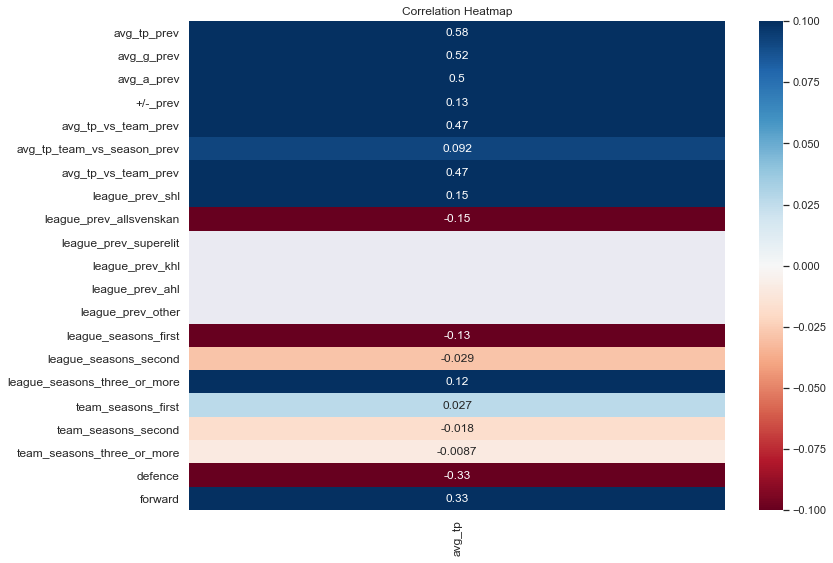

In [5]:
# Heatmap for correlations
plt.figure(figsize = (12, 9))
s = sns.heatmap(df_players_shl_clean.corr()[['avg_tp']][6:],
               annot = True, 
               cmap = 'RdBu',
               vmin = -0.1, 
               vmax = 0.1)
s.set_yticklabels(s.get_yticklabels(), rotation = 0, fontsize = 12)
s.set_xticklabels(s.get_xticklabels(), rotation = 90, fontsize = 12)
plt.title('Correlation Heatmap')
plt.show()

In [21]:
df_model = df_players_shl_clean[(df_players_shl_clean['season']!='2019-20') & 
                               (df_players_shl_clean['season']!='2020-21')].reset_index(drop=True)

df_2019 = df_players_shl_clean[(df_players_shl_clean['season']=='2019-20')].reset_index(drop=True)


df_2020 = df_players_shl[(df_players_shl['season']=='2020-21') & 
                        (~df_players_shl.iloc[:,10:].isnull().any(axis=1))].reset_index(drop=True)


In [22]:
y = df_model.iloc[:,5].values
X = df_model.iloc[:,12:].values
info = df_model.iloc[:,0:4].values

y_2019 = df_2019.iloc[:,5].values
X_2019 = df_2019.iloc[:,12:].values
info_2019 = df_2019.iloc[:,0:4].values

y_2020 = df_2020.iloc[:,5].values
X_2020 = df_2020.iloc[:,12:].values
info_2020 = df_2020.iloc[:,0:4].values



In [23]:
# Random state = 21 (random number)
X_train, X_test, y_train, y_test, info_train, info_test = train_test_split(X, y, info, 
                                                                           test_size = 0.2, random_state = 21)

# Feature Scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_2019 = scaler.transform(X_2019)
X_2020 = scaler.transform(X_2020)

### 4. Train model

Data is ready to be used to train the model. 

In [24]:
# Fitting Random Forest Classification to the Training set
rf = RandomForestRegressor(n_estimators = 100, random_state = 42)
rf.fit(X_train, y_train)

# save the model to disk
#filename = "C:/Users/marcu/Documents/projects/icehockey/ml_models/rf_predict_game.sav"
#pickle.dump(rf, open(filename, 'wb'))


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

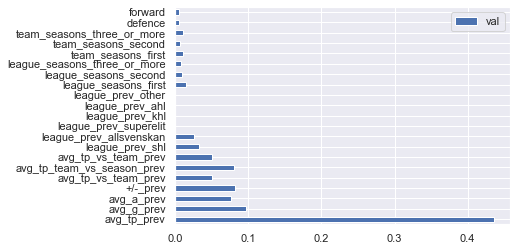

In [10]:
# Calculate feature importances
importances = rf.feature_importances_
# Sort feature importances in descending order
indices = np.argsort(importances)[::-1]

names = ['avg_tp_prev', 'avg_g_prev', 'avg_a_prev', '+/-_prev',
       'avg_tp_vs_team_prev', 'avg_tp_team_vs_season_prev',
       'avg_tp_vs_team_prev', 'league_prev_shl', 'league_prev_allsvenskan',
       'league_prev_superelit', 'league_prev_khl', 'league_prev_ahl',
       'league_prev_other', 'league_seasons_first', 'league_seasons_second',
       'league_seasons_three_or_more', 'team_seasons_first',
       'team_seasons_second', 'team_seasons_three_or_more', 'defence',
       'forward']


df = pd.DataFrame({'val': importances}, index=names)
ax = df.plot.barh(y='val')


### 5. Evaluate performance

Time to evaluate the performance of the model. This is done with precision and recall:  

* Precision: Proportion of positive predictions that was correct
* Recall: Proportion of actual positives that was identified

In [11]:
y_pred_rf = rf.predict(X_test)

info

#print(classification_report(y_test, y_pred_rf))

array([['Melker Karlsson ', 'FW', '2013-14', 'Skellefteå AIK'],
       ['Henrik Tömmernes ', 'DEF', '2016-17', 'Frölunda HC'],
       ['Niklas Arell ', 'DEF', '2013-14', 'Färjestad BK'],
       ...,
       ['Ville Lajunen ', 'DEF', '2013-14', 'Färjestad BK'],
       ['Dennis Rasmussen ', 'FW', '2013-14', 'Växjö Lakers HC'],
       ['Austin Farley ', 'FW', '2018-19', 'Luleå HF']], dtype=object)

### Check data for 2019
We are testing the model on the data for 2019. 

In [33]:
y_pred2019_rf = rf.predict(X_2019)

df_pred_2019 = pd.DataFrame(info_2019)
df_pred_2019.columns = ['playername', 'fw_def', 'season', 'team']

df_pred_2019['actual'] = y_2019
df_pred_2019['predicted_2019'] = y_pred2019_rf
df_pred_2019['prediction_error'] = df_pred_2019['actual'] - df_pred_2019['predicted_2019']

# Check mean values by sign
print('Average error : ', str(df_pred_2019['prediction_error'].mean()))
df_pred_2019

df_pred_2019[['playername', 'season', 'team', 'predicted_2019']].to_csv("C:/Users/marcu/Documents/projects/icehockey_analytics/data/df_2019_playerprediction.csv", index=False)


Average error :  -0.007782815767100447


In [34]:
y_pred2020_rf = rf.predict(X_2020)

df_pred_2020 = pd.DataFrame(info_2020)
df_pred_2020.columns = ['playername', 'fw_def', 'season', 'team']

df_pred_2020['predicted_2020'] = y_pred2020_rf

df_pred_2020

df_pred_2020[['playername', 'season', 'team', 'predicted_2020']].to_csv("C:/Users/marcu/Documents/projects/icehockey_analytics/data/df_2020_playerprediction.csv", index=False)